# **PEML MLP 2**
### Architecture 2 - PINN
Three years 2017 2018 2020

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a Optuna hyperparameters optimisation and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.

## **IMPORTANT NOTE**: 
- do preprocessing from ``preprocess.ipynb`` to obtain data in ``data/data_combined``, before starting this notebook
- make sure the notebook is under ``src`` directory before running!
- change the global variables defined below for the desired years of data, loss function and NN type



In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *
from modelling.physics import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import pickle

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
all other variables are defined in config.py

LOSS_FUNC: choose from 
- MSE
- LinearShift_MSE
- PDE_nmer_const
- PDE_nmer_piece
- PINN

In [ ]:
# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "PINN"
NN_TYPE = "MLP"
CITY = 'Utrecht' 

In [ ]:
if CITY == 'Utrecht':
    idx_dict = UTRECHT_IDX
    station_names = ['tuindorp', 'breukelen']
    main_station = 'breuklen'
elif CITY == 'Amsterdam':
    idx_dict = AMSTERDAM_IDX
    station_names = ['oudemeer', 'haarlem']
    main_station = 'haarlem'
elif CITY == 'Multi':
    idx_dict = MULTI_STATION_IDX
    station_names = ['tuindorp', 'breukelen', 'zegveld', 'oudemeer', 'kantershof']
    main_station = 'breukeln'
else:
    raise ValueError("CITY must be 'Utrecht', 'Amsterdam', or 'Multi'.")

## Automated Generation of paths and filenames according to data years, loss func, NN type
- will be used throughout the whole notebook
- check ``config.py`` for global variables defined outside the notebook

In [47]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS
    DATASET_PATH = DATASET_PATH_ALLYEARS

    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017
    DATASET_PATH = DATASET_PATH_2017
    print("Using 2017")
elif YEARS == [2017, 2018, 2020]:
    years = "first_3_years"
    MINMAX_PATH = MINMAX_PATH_FIRST3YEARS
    DATASET_PATH = DATASET_PATH_FIRST3YEARS
else:
    raise ValueError("Invalid years selected")

Y_PHY_FILENAME = f"y_phy_batchsize16_{LOSS_FUNC}_{years}"
MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth'
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.csv'
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt'
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.png'


print("Y_PHY_FILENAME", Y_PHY_FILENAME)
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using 2017
Y_PHY_FILENAME y_phy_batchsize16_PINN_2017
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/only_2017/pollutants_minmax_2017.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/only_2017
MODEL_PATH_NAME:  best_MLP_no2_PINN_2017.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_PINN_2017.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_PINN_2017.txt
PLOT_FILENAME:  plot_MLP_no2_PINN_2017.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

## Confirmation that the dataset has column indexes the same as those in ``config.py``
Indexes are used mainly for the physics calculations, in order to accurately extract the information needed

In [ ]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 tuindorp idx: ", column_names.index('NO2_TUINDORP'))
print("No2 breukelen idx: ", column_names.index('NO2_BREUKELEN'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_TUINDORP')== idx_dict[f"NO2_TUINDORP_IDX"]
assert column_names.index('NO2_BREUKELEN') == idx_dict[f"NO2_BREUKELEN_IDX"]
assert column_names.index('DD') == idx_dict[f"WIND_DIR_IDX"]
assert column_names.index('FH') == idx_dict[f"WIND_SPEED_IDX"]
print("Column indices are same as config.py")



No2 tuindorp idx:  5
No2 breukelen idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


## Tuning Hyperparameters with Optuna

In [22]:
print("tuning with loss function: ", LOSS_FUNC)
print("tuning with nn type: ", NN_TYPE)

tuning with loss function:  PINN
tuning with nn type:  MLP


In [23]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:

def objective(trial):
    # Define hyperparameters to search over
    set_seed(42)
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss, _ , _, _= model.train_model(train_loader, val_loader, epochs=50, 
                                    lr=lr, weight_decay=weight_decay, lambda_phy = lambda_phy, device=device, trial = trial, 
                                    idx_dict= idx_dict, station_names = station_names, main_station = main_station)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(
    direction="minimize", 
    study_name="mlp_hyperparameter_optimization_PINN_2017", 
    storage="sqlite:///mlp_hyperparameter_optimization_phy_pde.db", 
    load_if_exists=True,
    pruner=optuna.pruners.HyperbandPruner(),
    )

study.optimize(objective, n_trials=50)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [44]:
print(f"Best Hyperparameters for {NN_TYPE} with {LOSS_FUNC} for {years}:\n", best_params)

Best Hyperparameters for MLP with PINN for 2017:
 {'n_hidden_layers': 5, 'n_hidden_units': 155, 'lr': 9.934388934074838e-05, 'weight_decay': 2.1789824058154787e-06, 'lambda_phy': 5.257652378869103e-05, 'batch_size': 16}


## Save the params to a file
Parameters saved in ``src/results/best_params/best_params_MLP_no2_PINN_allyears.txt``

In [48]:
import json
best_params_file_path = f"{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}"

In [49]:
with open(best_params_file_path, "w") as f:
    json.dump(best_params, f, indent=4)  # Pretty format for readability

print(f"Best Hyperparameters saved to {best_params_file_path}")


Best Hyperparameters saved to /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_PINN_2017.txt


## Read params from file

In [50]:
with open(best_params_file_path, "r") as f:
    best_params = json.load(f)  # Automatically converts it to a dictionary

print("Loaded Best Parameters from file:", best_params_file_path)
print("Loaded Best Parameters:", best_params)


Loaded Best Parameters from file: /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_PINN_2017.txt
Loaded Best Parameters: {'n_hidden_layers': 5, 'n_hidden_units': 155, 'lr': 9.934388934074838e-05, 'weight_decay': 2.1789824058154787e-06, 'lambda_phy': 5.257652378869103e-05, 'batch_size': 16}


## Training and Saving Model
Model saved in ``src/results/models/best_MLP_no2_PINN_allyears.pth``

In [ ]:
set_seed(42)
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time, train_losses, val_losses = best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], 
                                                                    weight_decay=best_params["weight_decay"], lambda_phy= best_params['lambda_phy'], device=device, 
                                                                    idx_dict= idx_dict, station_names = station_names, main_station = main_station)
print(f"Training time: {training_time}")
# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Epoch 1/50 - Train Loss: 0.083567 - Val Loss: 0.139364
Epoch 2/50
Epoch 2/50 - Train Loss: 0.076768 - Val Loss: 0.127382
Epoch 3/50
Epoch 3/50 - Train Loss: 0.067227 - Val Loss: 0.115744
Epoch 4/50
Epoch 4/50 - Train Loss: 0.059615 - Val Loss: 0.103664
Epoch 5/50
Epoch 5/50 - Train Loss: 0.050712 - Val Loss: 0.091296
Epoch 6/50
Epoch 6/50 - Train Loss: 0.044079 - Val Loss: 0.078391
Epoch 7/50
Epoch 7/50 - Train Loss: 0.038850 - Val Loss: 0.065774
Epoch 8/50
Epoch 8/50 - Train Loss: 0.032935 - Val Loss: 0.053621
Epoch 9/50
Epoch 9/50 - Train Loss: 0.028371 - Val Loss: 0.045211
Epoch 10/50
Epoch 10/50 - Train Loss: 0.028021 - Val Loss: 0.041462
Epoch 11/50
Epoch 11/50 - Train Loss: 0.027254 - Val Loss: 0.041368
Epoch 12/50
Epoch 12/50 - Train Loss: 0.026542 - Val Loss: 0.042383
Epoch 13/50
Epoch 13/50 - Train Loss: 0.025536 - Val Loss: 0.041547
Epoch 14/50
Epoch 14/50 - Train Loss: 0.025643 - Val Loss: 0.039182
Epoch 15/50
Epoch 15/50 - Train Loss: 0.024043 - Val Loss: 0.03673

## Plot Train-Val
Plot saved in ``src/results/trainval_plots/trainval_plot_MLP_no2_PINN_allyears.png``


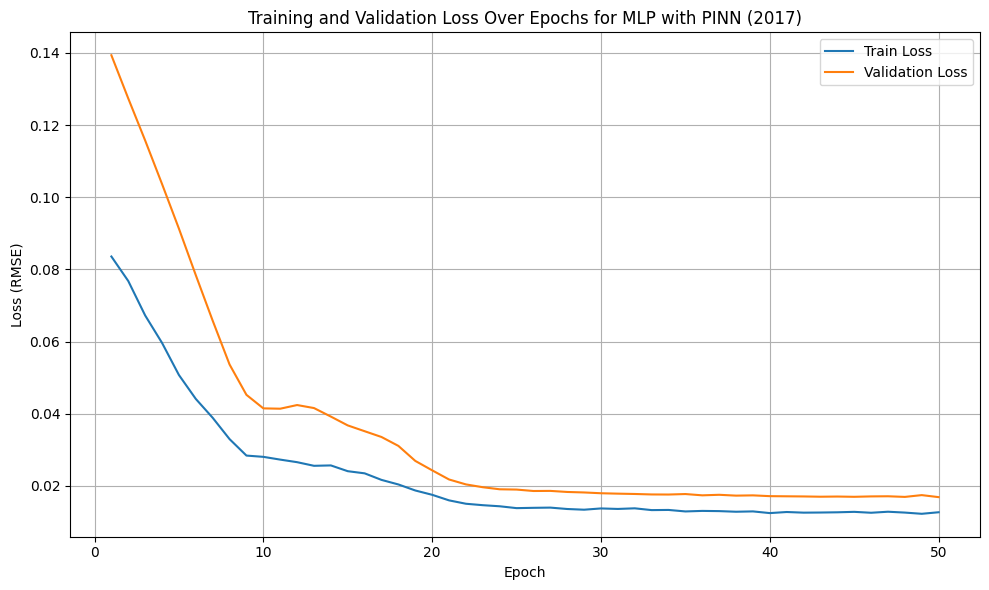

In [52]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.title(f"Training and Validation Loss Over Epochs for {NN_TYPE} with {LOSS_FUNC} ({years})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/trainval_plots/trainval_{PLOT_FILENAME}")
plt.show()


## Test and Save Results
Results saved in ``src/results/metrics/results_MLP_no2_PINN_allyears.csv``

In [53]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}"))
print(f"Model loaded from {MODEL_PATH}/{MODEL_PATH_NAME}")
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device=device)
print(f"Training time: {training_time}")



Model loaded from /home/rachel/forecasting_smog_PEML/src/results/models/best_MLP_no2_PINN_2017.pth
Test MSE Loss: 132.179534
Test RMSE Loss: 11.900903
Test SMAPE Loss: 30.285667%
Total Inference Time: 0.04 seconds
Training time: 27.14138960838318


In [54]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

Results saved as results_MLP_no2_PINN_2017.csv in Results/metrics folder


## Plot Model predictions vs True values
Plot saved ``src/results/plots/plot_MLP_no2_PINN_allyears.png``

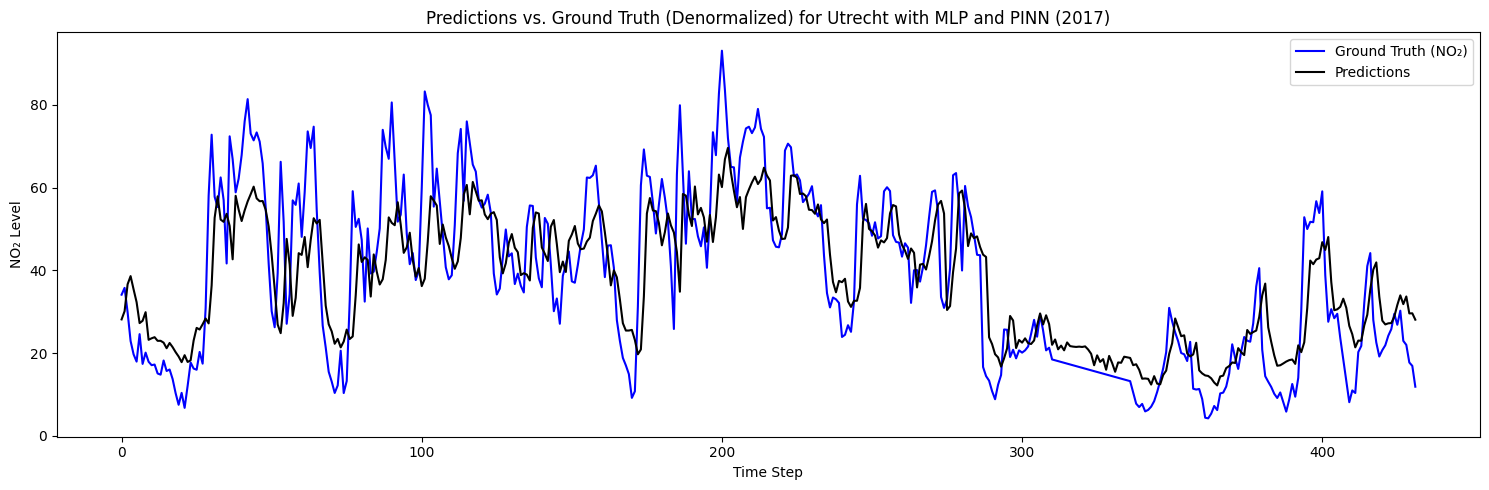

In [55]:
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load min and max values for denormalization
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = torch.tensor(df_minmax["min"].values, dtype=torch.float32)  # shape: (N_OUTPUT_UNITS,)
max_value = torch.tensor(df_minmax["max"].values, dtype=torch.float32)  # shape: (N_OUTPUT_UNITS,)

# Dynamically detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is on the right device and in eval mode
best_model.to(device)
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch
        x_test = x_test.to(device)
        y_true = y_true.to(device)

        # Get predictions
        y_pred = best_model(x_test)

        # Move to CPU and store
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Stack batches
y_preds = torch.cat(y_preds, dim=0)  # shape: (batch_size, n_hours_y, n_outputs)
y_trues = torch.cat(y_trues, dim=0)

# Denormalize
min_value = min_value.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, n_outputs)
max_value = max_value.unsqueeze(0).unsqueeze(0)
y_preds_denorm = y_preds * (max_value - min_value) + min_value
y_trues_denorm = y_trues * (max_value - min_value) + min_value

# Convert to numpy for plotting
y_preds_np = y_preds_denorm.numpy()
y_trues_np = y_trues_denorm.numpy()

# Plot 1 feature/channel (e.g., station 0)
feature_idx = 0
plt.figure(figsize=(15, 5))
plt.plot(y_trues_np[:, :, feature_idx].flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.plot(y_preds_np[:, :, feature_idx].flatten(), label="Predictions", linestyle="-", color="black")

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title(f"Predictions vs. Ground Truth (Denormalized) for Utrecht with {NN_TYPE} and {LOSS_FUNC} ({years})")
plt.legend()
plt.tight_layout()
# Save the plot
plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()
